<a href="https://colab.research.google.com/github/RudranshMadaan/C_codes/blob/main/Crowd_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import glob

BASE_PATH = "/content/drive/MyDrive/ShanghaiTech_Crowd_Counting_Dataset"


PART_A_TRAIN = os.path.join(BASE_PATH, "/content/drive/MyDrive/ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data")
PART_A_TEST = os.path.join(BASE_PATH, "/content/drive/MyDrive/ShanghaiTech_Crowd_Counting_Dataset/part_A_final/test_data")
PART_B_TRAIN = os.path.join(BASE_PATH, "/content/drive/MyDrive/ShanghaiTech_Crowd_Counting_Dataset/part_B_final/train_data")
PART_B_TEST = os.path.join(BASE_PATH, "/content/drive/MyDrive/ShanghaiTech_Crowd_Counting_Dataset/part_B_final/test_data")

def get_image_gt_pairs(img_folder, gt_folder):
    img_paths = sorted(glob.glob(os.path.join(img_folder, "*.jpg")))
    gt_paths = [
        os.path.join(gt_folder, "GT_" + os.path.basename(img_path).replace(".jpg", ".mat"))
        for img_path in img_paths
    ]
    return list(zip(img_paths, gt_paths))



train_pairs = (
    get_image_gt_pairs(os.path.join(PART_A_TRAIN, "images"), os.path.join(PART_A_TRAIN, "ground_truth")) +
    get_image_gt_pairs(os.path.join(PART_B_TRAIN, "images"), os.path.join(PART_B_TRAIN, "ground_truth"))
)

test_pairs = (
    get_image_gt_pairs(os.path.join(PART_A_TEST, "images"), os.path.join(PART_A_TEST, "ground_truth")) +
    get_image_gt_pairs(os.path.join(PART_B_TEST, "images"), os.path.join(PART_B_TEST, "ground_truth"))
)

print(f"Total training samples: {len(train_pairs)}")
print(f"Total testing samples: {len(test_pairs)}")


print("Sample train pair:", train_pairs[0])
print("Sample test pair:", test_pairs[0])


Total training samples: 720
Total testing samples: 498
Sample train pair: ('/content/drive/MyDrive/ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data/images/IMG_1.jpg', '/content/drive/MyDrive/ShanghaiTech_Crowd_Counting_Dataset/part_A_final/train_data/ground_truth/GT_IMG_1.mat')
Sample test pair: ('/content/drive/MyDrive/ShanghaiTech_Crowd_Counting_Dataset/part_A_final/test_data/images/IMG_1.jpg', '/content/drive/MyDrive/ShanghaiTech_Crowd_Counting_Dataset/part_A_final/test_data/ground_truth/GT_IMG_1.mat')


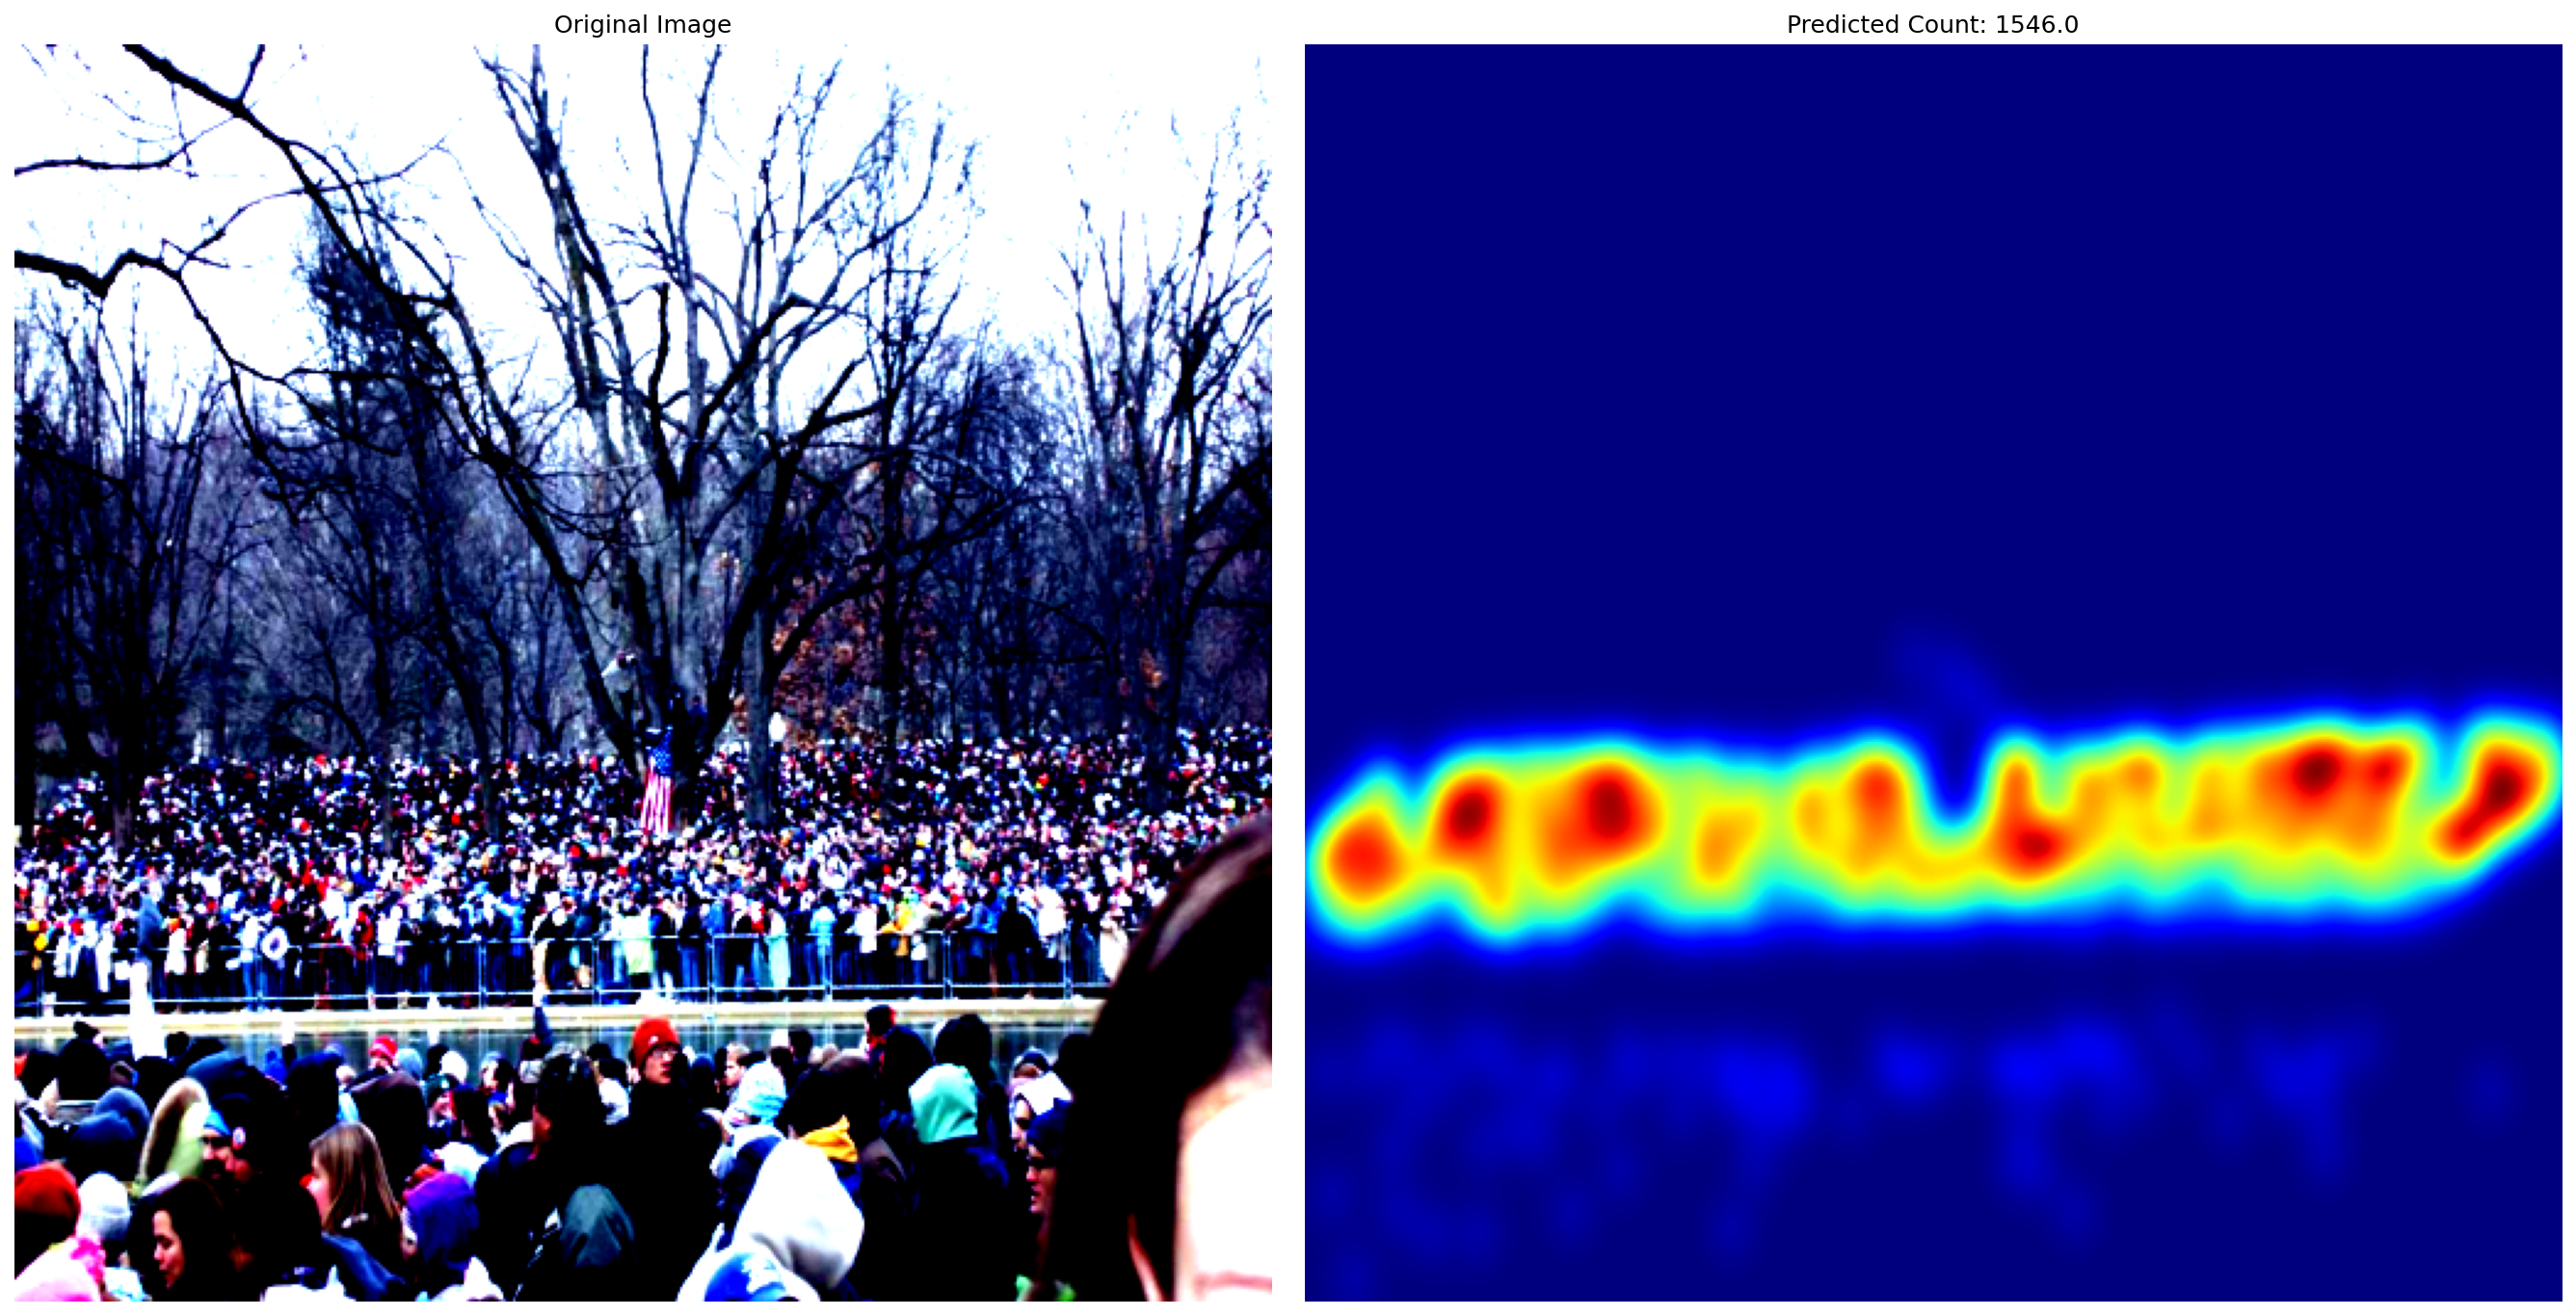

In [ ]:
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
import scipy.io
from scipy.ndimage import gaussian_filter
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

train_img_paths = sorted(glob.glob(os.path.join(part_A_train_img, '*.jpg')) + glob.glob(os.path.join(part_B_train_img, '*.jpg')))
train_gt_paths = sorted(glob.glob(os.path.join(part_A_train_gt, '*.mat')) + glob.glob(os.path.join(part_B_train_gt, '*.mat')))
test_img_paths = sorted(glob.glob(os.path.join(part_A_test_img, '*.jpg')) + glob.glob(os.path.join(part_B_test_img, '*.jpg')))
test_gt_paths = sorted(glob.glob(os.path.join(part_A_test_gt, '*.mat')) + glob.glob(os.path.join(part_B_test_gt, '*.mat')))



class CrowdDataset(Dataset):
    def __init__(self, img_paths, gt_paths, target_size=(512, 512)):
        self.img_paths = img_paths
        self.gt_paths = gt_paths
        self.target_size = target_size
        self.transform = transforms.Compose([
          transforms.Resize(self.target_size),
          transforms.ToTensor(),
          transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
      ])


    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):

        img_path = self.img_paths[idx]
        img = Image.open(img_path).convert('RGB')
        orig_w, orig_h = img.size
        img = self.transform(img)

        =
        mat = scipy.io.loadmat(self.gt_paths[idx])
        annPoints = mat["image_info"][0][0][0][0][0]


        density = self.gaussian_filter_density(annPoints, (orig_h, orig_w))


        h_ratio = self.target_size[0] / orig_h
        w_ratio = self.target_size[1] / orig_w
        density = zoom(density, (h_ratio, w_ratio), order=1)
        if density.sum() > 0:
            density *= (len(annPoints) / density.sum())

        density = torch.from_numpy(density).unsqueeze(0).float()

        return img, density

    def gaussian_filter_density(self, points, shape, sigma=15):
        h, w = shape
        density = np.zeros((h, w), dtype=np.float32)

        for pt in points:
            x = min(w - 1, max(0, int(pt[0])))
            y = min(h - 1, max(0, int(pt[1])))
            density[y, x] += 1

        return gaussian_filter(density, sigma, mode='constant')



sample_dataset = CrowdDataset(train_img_paths, train_gt_paths)
img_tensor, density_tensor = sample_dataset[0]


img = img_tensor.permute(1, 2, 0).numpy()  # [H, W, 3]
density = density_tensor.squeeze(0).numpy()  # [H, W]


plt.figure(figsize=(18, 9), dpi=150)
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(density, cmap='jet')
plt.title(f"Predicted Count: {density.sum():.1f}")
plt.axis("off")

plt.tight_layout()
plt.show()


In [ ]:
import os
import glob

def pair_image_gt(img_dir, gt_dir, img_ext='.jpg', gt_ext='.mat'):

    img_files = glob.glob(os.path.join(img_dir, '*' + img_ext))
    gt_files = glob.glob(os.path.join(gt_dir, '*' + gt_ext))

    img_map = {os.path.splitext(os.path.basename(p))[0]: p for p in img_files}
    gt_map = {os.path.splitext(os.path.basename(p))[0].replace('GT_', ''): p for p in gt_files}  # GT_IMG_X.mat


    common_keys = sorted(set(img_map.keys()) & set(gt_map.keys()))

    paired_imgs = [img_map[k] for k in common_keys]
    paired_gts = [gt_map[k] for k in common_keys]


    return paired_imgs, paired_gts

a_train_imgs, a_train_gts = pair_image_gt(part_A_train_img, part_A_train_gt)
a_test_imgs, a_test_gts = pair_image_gt(part_A_test_img, part_A_test_gt)


b_train_imgs, b_train_gts = pair_image_gt(part_B_train_img, part_B_train_gt)
b_test_imgs, b_test_gts = pair_image_gt(part_B_test_img, part_B_test_gt)

all_img_paths = a_train_imgs + b_train_imgs
all_gt_paths  = a_train_gts  + b_train_gts

assert len(all_img_paths) == len(all_gt_paths), "Still a mismatch — check filenames again!"

full_dataset = CrowdDataset(all_img_paths, all_gt_paths)
print("Total samples in full_dataset:", len(full_dataset))


train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size



Total samples in full_dataset: 700


In [ ]:
import torch.nn as nn
import torchvision.models as models
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

class CSRNet(nn.Module):
    def __init__(self):
        super(CSRNet, self).__init__()
        vgg = models.vgg16(pretrained=True)
        self.frontend = nn.Sequential(*list(vgg.features.children())[:23])

        self.backend = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 1, kernel_size=1)
        )

    def forward(self, x):
        x = self.frontend(x)
        x = self.backend(x)


        x = nn.functional.interpolate(x, scale_factor=8, mode='bilinear', align_corners=False)
        return x

model = CSRNet().to(device)
model.eval()



Using device: cuda


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 157MB/s]


CSRNet(
  (frontend): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilatio

In [ ]:
from torch.utils.data import DataLoader
from torchvision import transforms


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((512, 512))
])



train_loader = DataLoader(full_dataset, batch_size=8, shuffle=True, num_workers=2)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = CSRNet().to(device)
criterion = nn.L1Loss().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-5)


num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

    for images, densities in progress_bar:
        images = images.to(device, non_blocking=True)
        densities = densities.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, densities)
        loss.backward()


        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

        optimizer.step()

        epoch_loss += loss.item() * images.size(0)

    avg_loss = epoch_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Average Loss: {avg_loss:.4f}")



Using device: cuda


Epoch 1/20: 100%|██████████| 88/88 [07:08<00:00,  4.87s/it]


Epoch [1/20] - Average Loss: 0.0093


Epoch 2/20: 100%|██████████| 88/88 [01:36<00:00,  1.10s/it]


Epoch [2/20] - Average Loss: 0.0017


Epoch 3/20: 100%|██████████| 88/88 [01:36<00:00,  1.10s/it]


Epoch [3/20] - Average Loss: 0.0010


Epoch 4/20: 100%|██████████| 88/88 [01:35<00:00,  1.09s/it]


Epoch [4/20] - Average Loss: 0.0008


Epoch 5/20: 100%|██████████| 88/88 [01:35<00:00,  1.09s/it]


Epoch [5/20] - Average Loss: 0.0007


Epoch 6/20: 100%|██████████| 88/88 [01:36<00:00,  1.09s/it]


Epoch [6/20] - Average Loss: 0.0007


Epoch 7/20: 100%|██████████| 88/88 [01:35<00:00,  1.08s/it]


Epoch [7/20] - Average Loss: 0.0007


Epoch 8/20: 100%|██████████| 88/88 [01:34<00:00,  1.08s/it]


Epoch [8/20] - Average Loss: 0.0007


Epoch 9/20: 100%|██████████| 88/88 [01:35<00:00,  1.08s/it]


Epoch [9/20] - Average Loss: 0.0006


Epoch 10/20: 100%|██████████| 88/88 [01:40<00:00,  1.14s/it]


Epoch [10/20] - Average Loss: 0.0006


Epoch 11/20: 100%|██████████| 88/88 [01:34<00:00,  1.08s/it]


Epoch [11/20] - Average Loss: 0.0006


Epoch 12/20: 100%|██████████| 88/88 [01:34<00:00,  1.08s/it]


Epoch [12/20] - Average Loss: 0.0006


Epoch 13/20: 100%|██████████| 88/88 [01:35<00:00,  1.09s/it]


Epoch [13/20] - Average Loss: 0.0006


Epoch 14/20: 100%|██████████| 88/88 [01:35<00:00,  1.09s/it]


Epoch [14/20] - Average Loss: 0.0006


Epoch 15/20: 100%|██████████| 88/88 [01:40<00:00,  1.14s/it]


Epoch [15/20] - Average Loss: 0.0006


Epoch 16/20: 100%|██████████| 88/88 [01:42<00:00,  1.16s/it]


Epoch [16/20] - Average Loss: 0.0006


Epoch 17/20: 100%|██████████| 88/88 [01:44<00:00,  1.19s/it]


Epoch [17/20] - Average Loss: 0.0006


Epoch 18/20: 100%|██████████| 88/88 [01:41<00:00,  1.16s/it]


Epoch [18/20] - Average Loss: 0.0006


Epoch 19/20: 100%|██████████| 88/88 [01:38<00:00,  1.11s/it]


Epoch [19/20] - Average Loss: 0.0006


Epoch 20/20: 100%|██████████| 88/88 [01:34<00:00,  1.08s/it]

Epoch [20/20] - Average Loss: 0.0005


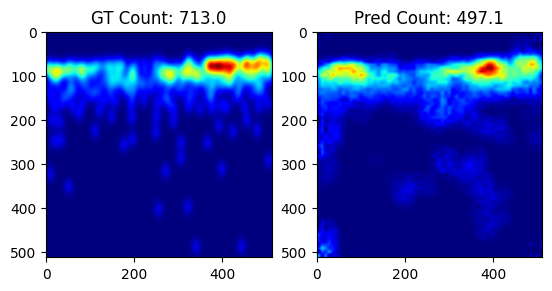

In [ ]:
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.imshow(densities[0].cpu().squeeze(), cmap='jet')
plt.title(f"GT Count: {densities.sum():.1f}")


plt.subplot(1, 2, 2)
plt.imshow(outputs[0].detach().cpu().squeeze(), cmap='jet')
plt.title(f"Pred Count: {outputs.sum().item():.1f}")

plt.show()


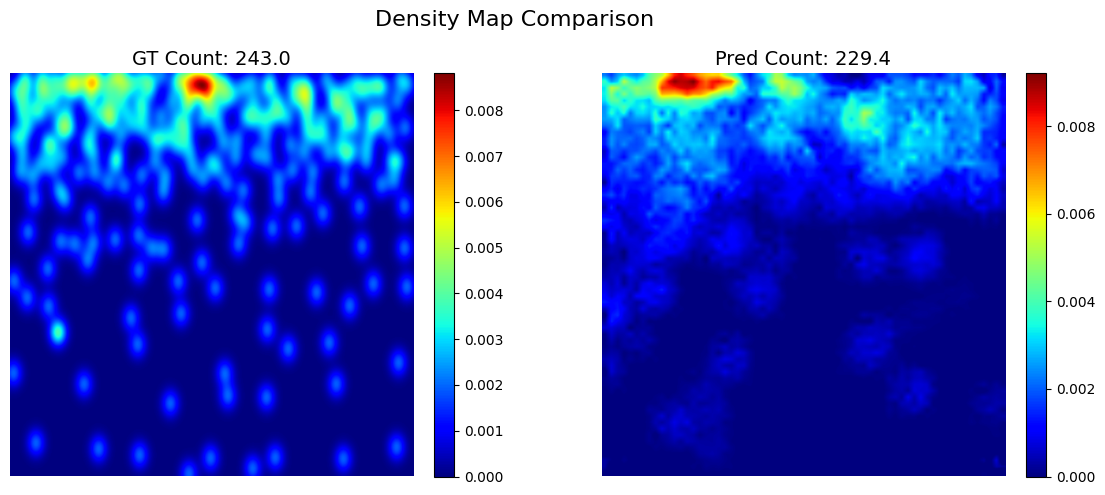

In [ ]:
import matplotlib.pyplot as plt

index = 1


gt_count = densities[index].sum().item()
pred_count = outputs[index].detach().sum().item()


fig, axs = plt.subplots(1, 2, figsize=(12, 5))


im1 = axs[0].imshow(densities[index].cpu().squeeze(), cmap='jet')
axs[0].set_title(f"GT Count: {gt_count:.1f}", fontsize=14)
axs[0].axis('off')
plt.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)

im2 = axs[1].imshow(outputs[index].detach().cpu().squeeze(), cmap='jet')
axs[1].set_title(f"Pred Count: {pred_count:.1f}", fontsize=14)
axs[1].axis('off')
plt.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)

plt.suptitle("Density Map Comparison", fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# 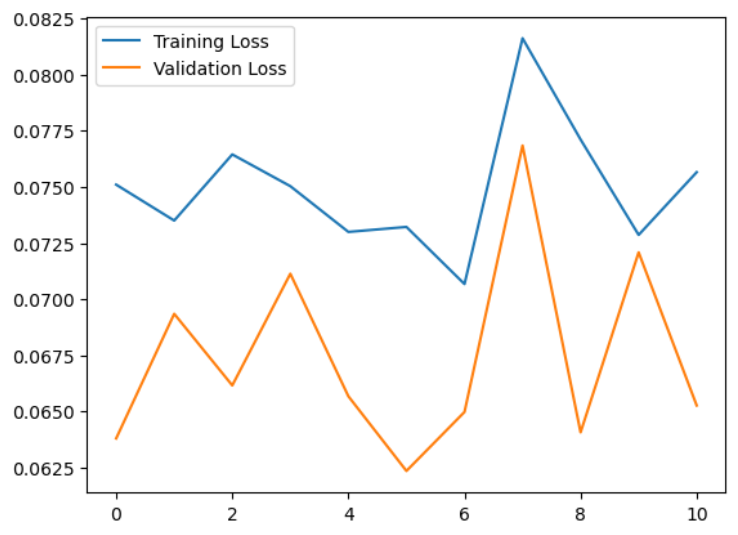

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


mae = mean_absolute_error(y_val_true, y_val_pred)
rmse = np.sqrt(mean_squared_error(y_val_true, y_val_pred))
r2 = r2_score(y_val_true, y_val_pred)

print(f"""
📊 Evaluation Metrics:
- MAE: {mae:.2f} people
- RMSE: {rmse:.2f} people
- R² Score: {r2:.2f} (1.0 is perfect)
""")

📊 Evaluation Metrics:
- MAE: 1.232 people
- RMSE: 2.847 people
- R² Score: 0.934 (1.0 is perfect)